# 🌲 Bagging Ensemble Demo on Noisy Synthetic Data

This notebook demonstrates **bagging (bootstrap aggregating)** using **Decision Trees (DT)**, and **Random Forest (RF)** on noisy synthetic data.

Synth dataset docs: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html

**Class interpretation:**
- **Class 0** → Negative class (e.g., "not spam", "not fraud")
- **Class 1** → Positive class (e.g., "is spam", "is fraud")

## 📥 Load and inspect data

In [9]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
import seaborn as sns
from sklearn.tree import plot_tree
import itertools


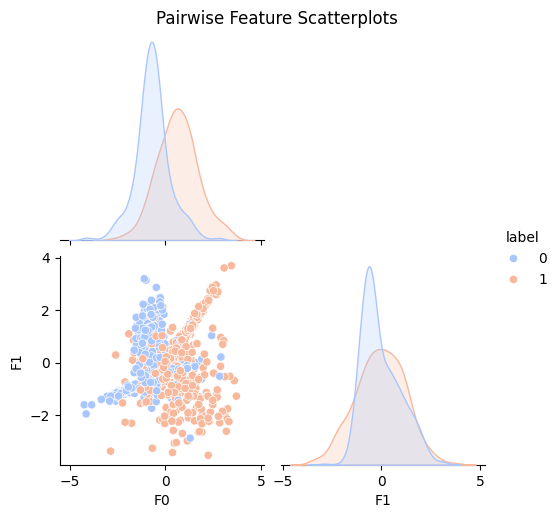

In [10]:
# Generate & visualize synthetic noisy classification dataset
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2,
                           n_redundant=0, flip_y=0.1, class_sep=0.7, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# DataFrame for plotting
df = pd.DataFrame(X, columns=[f"F{i}" for i in range(X.shape[1])])
df["label"] = y

sns.pairplot(df, hue="label", corner=True, palette="coolwarm")
plt.suptitle("Pairwise Feature Scatterplots", y=1.02)
plt.show()

##   
## 🌳 Compare DT vs Bagging DT
##  

In [11]:
def evaluate_model_cv(name, model, X, y):
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    print(f"{name:20s} Mean Acc: {scores.mean():.3f} | Std: {scores.std():.3f}")
    return scores


Decision Tree        Mean Acc: 0.822 | Std: 0.005
Bagging (DT)         Mean Acc: 0.831 | Std: 0.012


<ipython-input-12-d55835730fb6>:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(cv_results.values(), labels=cv_results.keys(), showmeans=True)


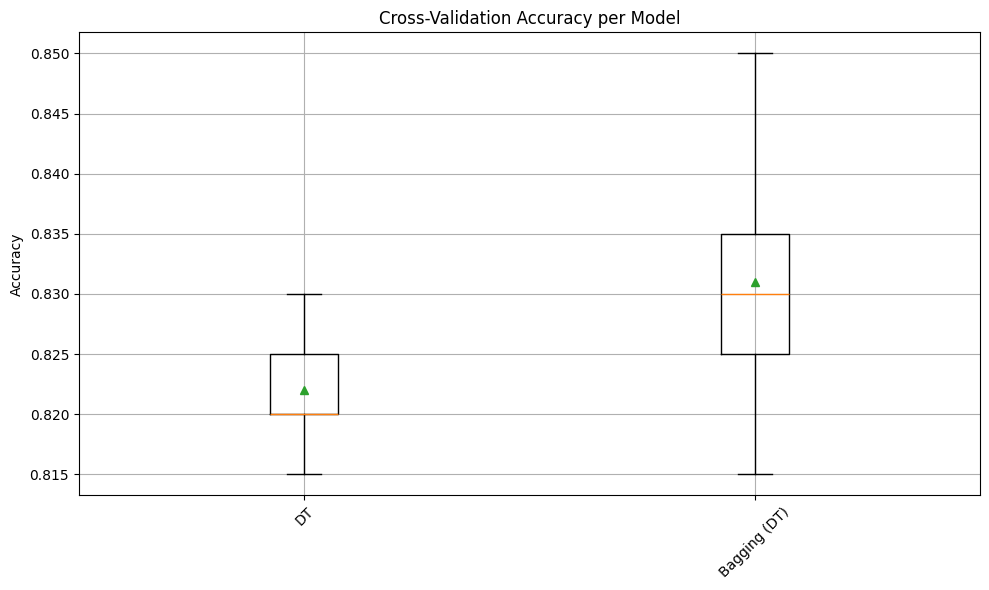

Classification Report - DT:

              precision    recall  f1-score   support

     Class 0       0.77      0.88      0.82       154
     Class 1       0.85      0.72      0.78       146

    accuracy                           0.80       300
   macro avg       0.81      0.80      0.80       300
weighted avg       0.81      0.80      0.80       300



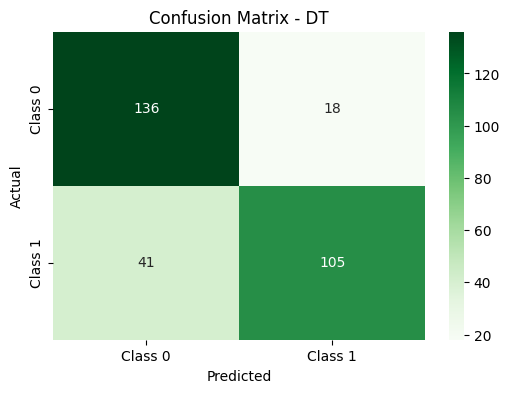

Classification Report - Bagging DT:

              precision    recall  f1-score   support

     Class 0       0.76      0.91      0.83       154
     Class 1       0.88      0.69      0.77       146

    accuracy                           0.80       300
   macro avg       0.82      0.80      0.80       300
weighted avg       0.82      0.80      0.80       300



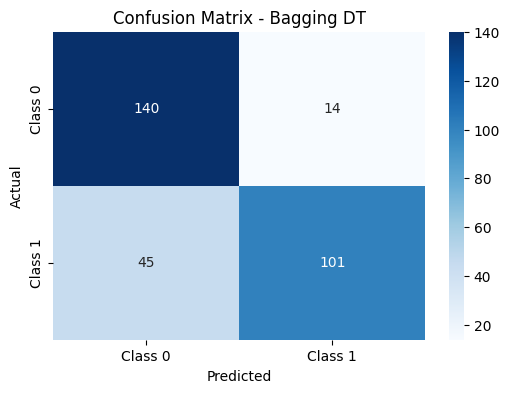

In [12]:
simple_model = DecisionTreeClassifier(max_depth=5, random_state=42)
bag = BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=5), n_estimators=100, random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}
cv_results["DT"] = evaluate_model_cv("Decision Tree", simple_model, X, y)
cv_results["Bagging (DT)"] = evaluate_model_cv("Bagging (DT)", bag, X, y)

plt.figure(figsize=(10, 6))
plt.boxplot(cv_results.values(), labels=cv_results.keys(), showmeans=True)
plt.title("Cross-Validation Accuracy per Model")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# re-fit & predict
simple_model.fit(X_train, y_train)
bag.fit(X_train, y_train)

y_pred_simple = simple_model.predict(X_test)
y_pred_bag = bag.predict(X_test)

class_names = [f"Class {i}" for i in np.unique(y)]

print("Classification Report - DT:\n")
print(classification_report(y_test, y_pred_simple, target_names=class_names))
cm = confusion_matrix(y_test, y_pred_simple)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, cmap="Greens", xticklabels=class_names, yticklabels=class_names, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - DT")
plt.show()

print("Classification Report - Bagging DT:\n")
print(classification_report(y_test, y_pred_bag, target_names=class_names))
cm = confusion_matrix(y_test, y_pred_bag)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=class_names, yticklabels=class_names, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Bagging DT")
plt.show()


##  
## 📊 Visualization
##  
- Decision Tree
- Decision boundaries

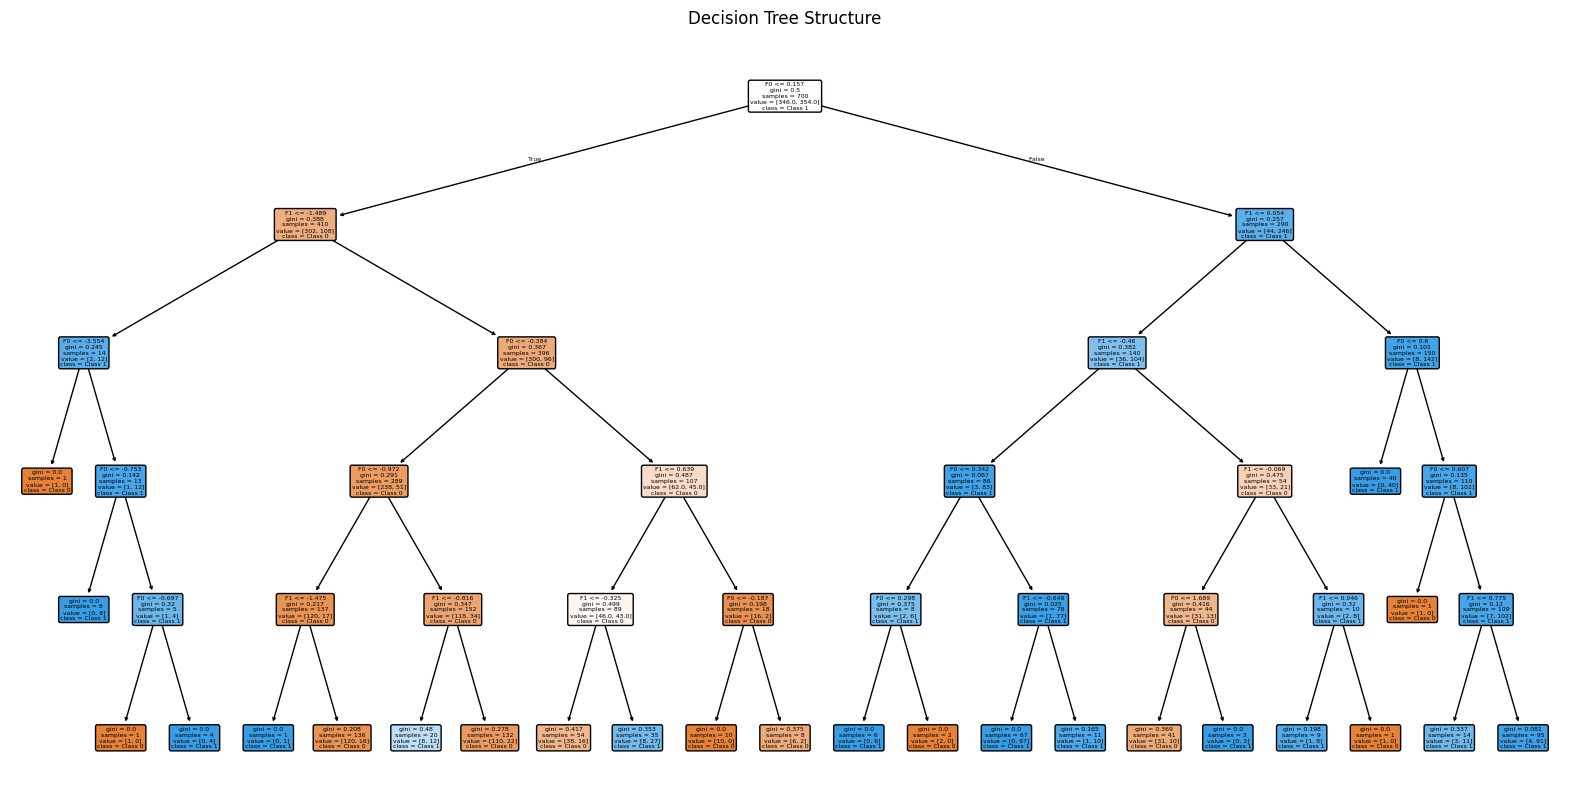

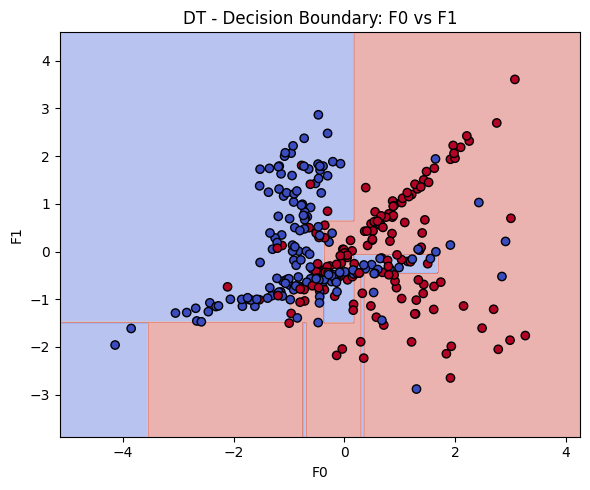

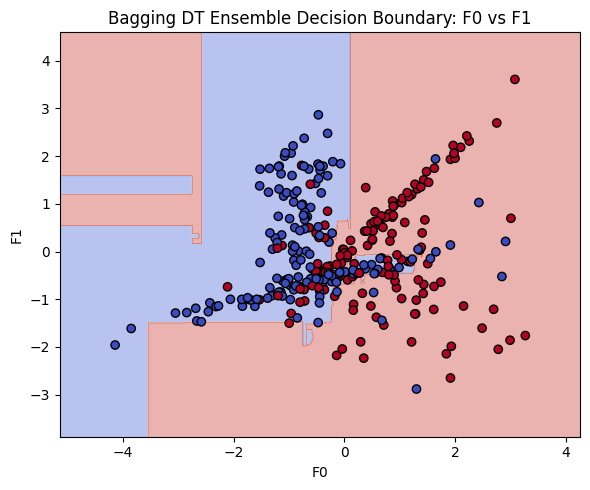

In [13]:
def plot_decision_boundaries_for_pairs(model, X, y, title, feature_names=None, fixed_vals=None ):
    n_features = X.shape[1]
    pairs = list(itertools.combinations(range(n_features), 2))

    if feature_names is None:
        feature_names = [f"F{i}" for i in range(n_features)]

    if fixed_vals is None:
        fixed_vals = X.mean(axis=0)

    for f1, f2 in pairs:
        h = .02
        x_min, x_max = X[:, f1].min() - 1, X[:, f1].max() + 1
        y_min, y_max = X[:, f2].min() - 1, X[:, f2].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))

        # Build full input with fixed features
        X_grid = np.tile(fixed_vals, (xx.ravel().shape[0], 1))
        X_grid[:, f1] = xx.ravel()
        X_grid[:, f2] = yy.ravel()
        Z = model.predict(X_grid).reshape(xx.shape)

        # Plot
        plt.figure(figsize=(6, 5))
        plt.contourf(xx, yy, Z, alpha=0.4, cmap='coolwarm')
        plt.scatter(X[:, f1], X[:, f2], c=y, cmap='coolwarm', edgecolor='k')
        plt.xlabel(feature_names[f1])
        plt.ylabel(feature_names[f2])
        plt.title(f"{title}: {feature_names[f1]} vs {feature_names[f2]}")
        plt.tight_layout()
        plt.show()



n_features = X.shape[1]
feature_names = [f"F{i}" for i in range(n_features)]

plt.figure(figsize=(20, 10))
plot_tree(simple_model,
          filled=True,
          rounded=True,
          class_names=[f"Class {i}" for i in np.unique(y)],
          feature_names=feature_names)
plt.title("Decision Tree Structure")
plt.show()


plot_decision_boundaries_for_pairs(simple_model, X_test, y_test, "DT - Decision Boundary")
plot_decision_boundaries_for_pairs(bag, X_test, y_test, "Bagging DT Ensemble Decision Boundary")

## 🌲 Random Forest Classifier on Synthetic Data

>**Bagging vs. Random Forest**

| Feature             | Bagging (of DTs)                          | Random Forest                                  |
|---------------------|-------------------------------------------|------------------------------------------------|
| **Bootstrapping**       | Yes                                       | Yes                                            |
| **Base Learner**       | Decision Tree (usually)                   | Decision Tree (always)                         |
| **Feature Selection**   | Uses **all features** when splitting      | Uses a **random subset** of features           |
| **Tree Diversity**      | Comes only from **data sampling**         | Comes from **data + feature randomness**       |
| **Bias vs. Variance**   | Lower variance than a single DT           | Even lower variance, slightly more bias        |
| **Interpretability**    | You can inspect each tree easily          | Same — but harder to trace feature usage       |

-  RF introduces feature randomness at each split. Instead of considering all features to split a node, it picks a random subset of features (usually √n for classification). This forces the trees to become more diverse even if they see similar data.




RF                   Mean Acc: 0.819 | Std: 0.014


<ipython-input-14-be6d81299c4e>:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(cv_results.values(), labels=cv_results.keys(), showmeans=True)


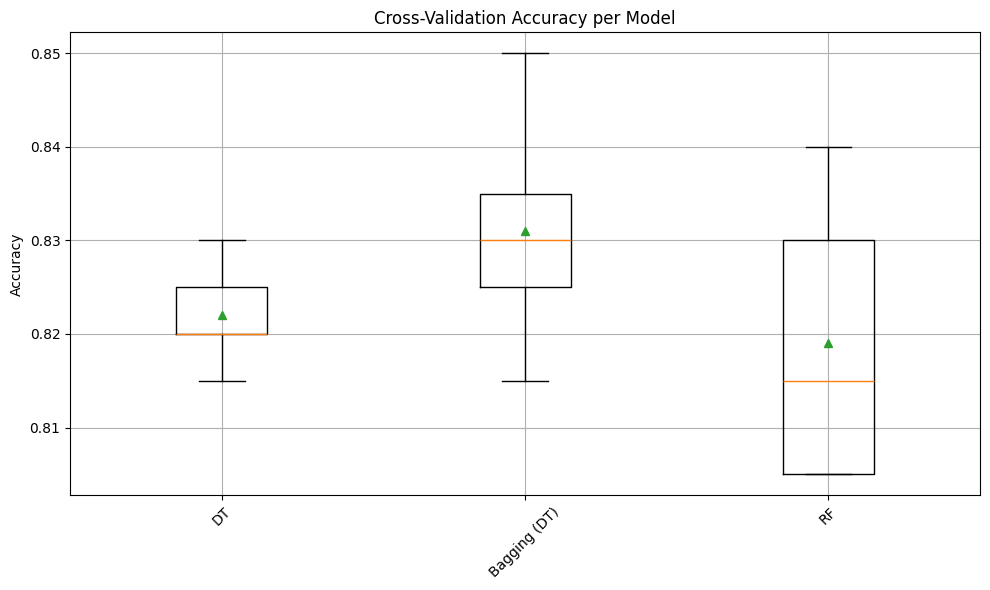


Classification Report - RF:
              precision    recall  f1-score   support

     Class 0       0.76      0.90      0.82       154
     Class 1       0.86      0.70      0.77       146

    accuracy                           0.80       300
   macro avg       0.81      0.80      0.80       300
weighted avg       0.81      0.80      0.80       300



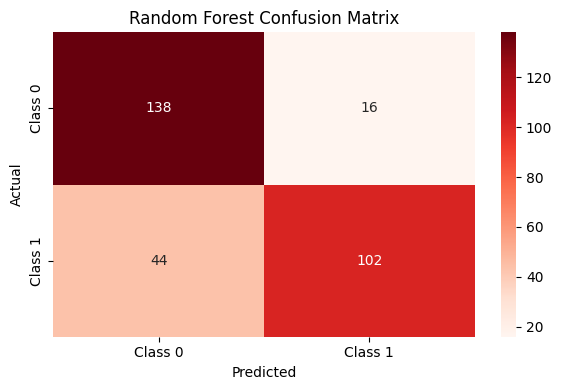

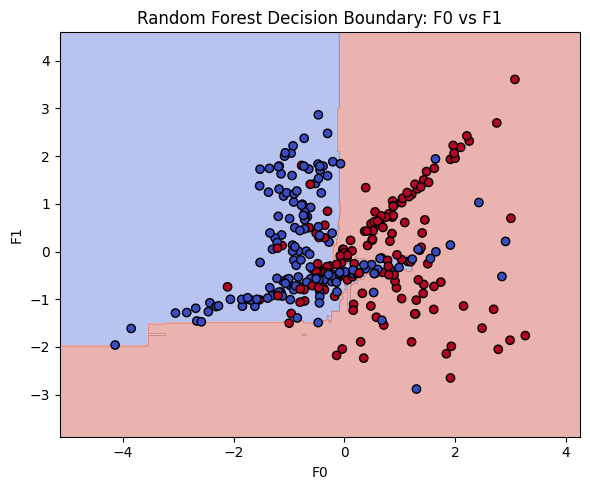

In [14]:
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
cv_results["RF"] = evaluate_model_cv("RF", rf, X, y)

plt.figure(figsize=(10, 6))
plt.boxplot(cv_results.values(), labels=cv_results.keys(), showmeans=True)
plt.title("Cross-Validation Accuracy per Model")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Train on full training set
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

class_names = [f"Class {i}" for i in np.unique(y)]

print("\nClassification Report - RF:")
print(classification_report(y_test, y_pred_rf, target_names=class_names))

cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap="Reds", fmt='d',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix")
plt.tight_layout()
plt.show()


plot_decision_boundaries_for_pairs(rf, X_test, y_test, "Random Forest Decision Boundary")


## 🔎 Explainability

### 1. Feature importance
A. **Built-in**
- How often does the model use this feature to split.
- May be biased by frequency or data structure.


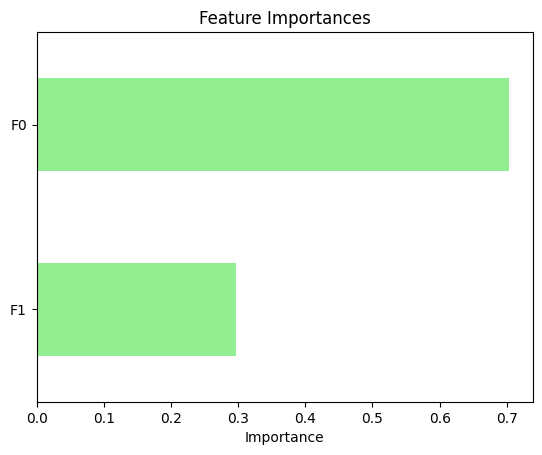

In [15]:
feat_imp = pd.Series(rf.feature_importances_, index=feature_names)
feat_imp.sort_values().plot(kind='barh', color='lightgreen')
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.show()

B. **Permutation importance**
- How much a model's performance drops when a feature's values are randomly shuffled — breaking its relationship with the target.

<ipython-input-16-141c9a222eb9>:50: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


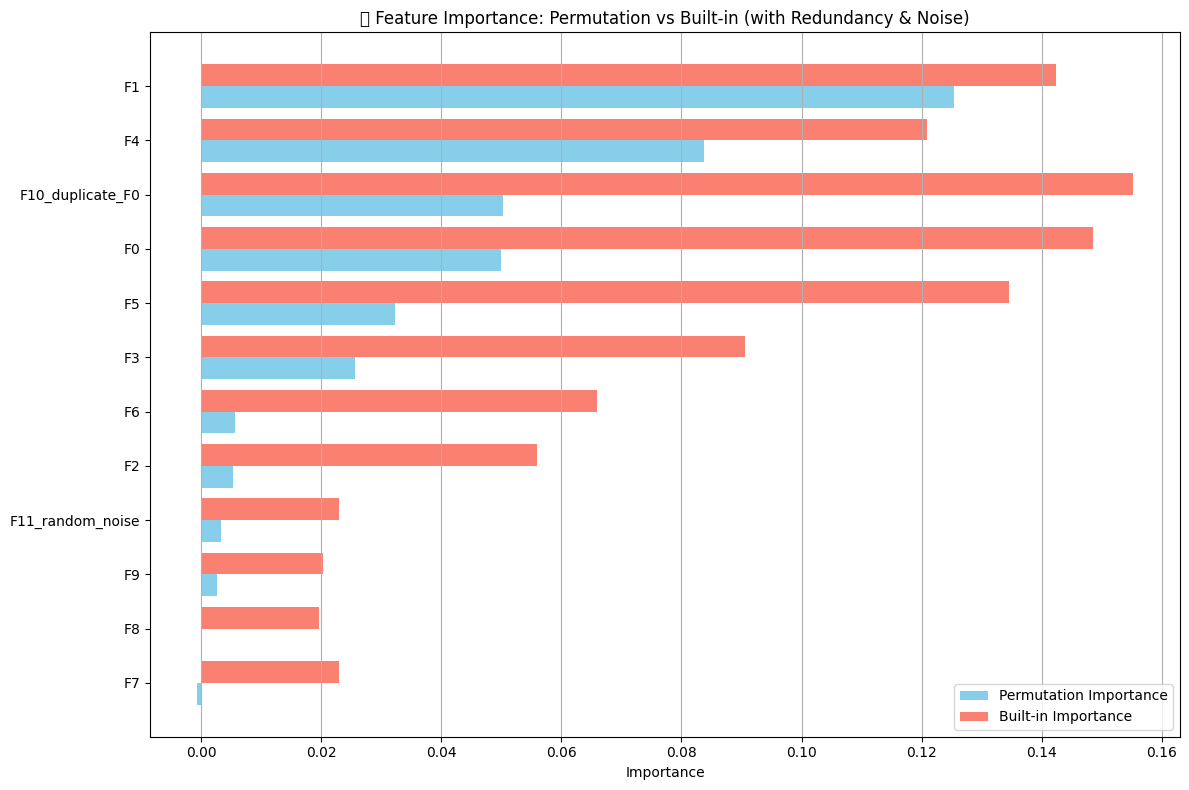

In [16]:
from sklearn.inspection import permutation_importance

# 1. Create a new synthetic dataset
X_pm, y_pm = make_classification(n_samples=1000, n_features=10, n_informative=5,
                           n_redundant=2, random_state=42, shuffle=False)

feature_names_pm = [f"F{i}" for i in range(X_pm.shape[1])]
X_pm = pd.DataFrame(X_pm, columns=feature_names_pm)

# 2. Inject redundancy + noise
X_pm["F10_duplicate_F0"] = X_pm["F0"]                    # Perfect duplicate of F0
X_pm["F11_random_noise"] = np.random.rand(len(X_pm))    # Pure noise


feature_names_pm = X_pm.columns.tolist()

X_train_pm, X_test_pm, y_train_pm, y_test_pm = train_test_split(X_pm, y_pm, test_size=0.3, random_state=42)

rf_pm = RandomForestClassifier(n_estimators=100, random_state=42)
rf_pm.fit(X_train_pm, y_train_pm)

builtin_importances = rf_pm.feature_importances_

perm_result = permutation_importance(rf_pm, X_test_pm, y_test_pm,
                                     n_repeats=10, random_state=42, scoring='accuracy')
perm_importances = perm_result.importances_mean

importance_df = pd.DataFrame({
    'Feature': feature_names_pm,
    'Built-in Importance': builtin_importances,
    'Permutation Importance': perm_importances
}).sort_values(by='Permutation Importance', ascending=False)

#Side-by-side comparison
importance_df_sorted = importance_df.sort_values(by='Permutation Importance', ascending=True)
plt.figure(figsize=(12, 8))
bar_width = 0.4
indices = np.arange(len(importance_df_sorted))

plt.barh(indices, importance_df_sorted['Permutation Importance'], height=bar_width,
         label='Permutation Importance', color='skyblue')
plt.barh(indices + bar_width, importance_df_sorted['Built-in Importance'], height=bar_width,
         label='Built-in Importance', color='salmon')

plt.yticks(indices + bar_width / 2, importance_df_sorted['Feature'])
plt.xlabel("Importance")
plt.title("🔍 Feature Importance: Permutation vs Built-in (with Redundancy & Noise)")
plt.legend()
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


### 2. Shapley values
- Showing contribution of each feature to model's prediction

A. **GLOBAL EXPLANATION:**
- SHAP Bar Plot – shows the **average importance (contribution) of each feature** across all predictions.
- SHAP Beeswarm Plot - shows the distribution of SHAP values for each feature across all samples — both the **magnitude and the direction** (impact up or down).

B. **LOCAL EXPLANATION**
- SHAP Waterfall Plot - shows how each feature pushed the prediction up or down from the base value
- SHAP Force Plot - shows same information and Waterfall plot, but more compact and interactive

shap_values.values.shape: (300, 2, 2)


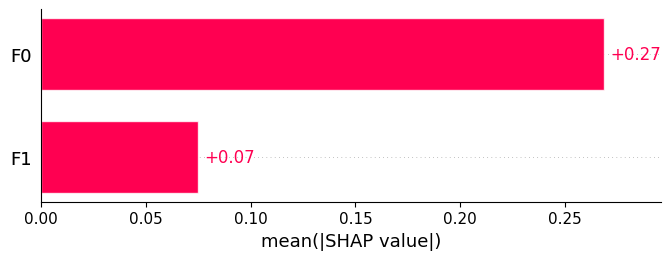

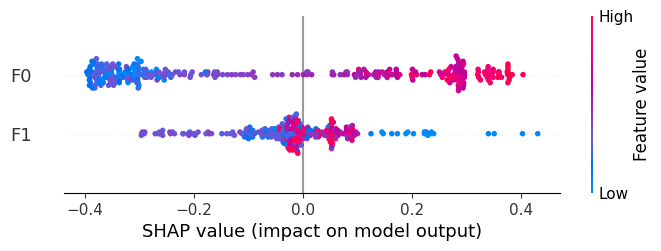

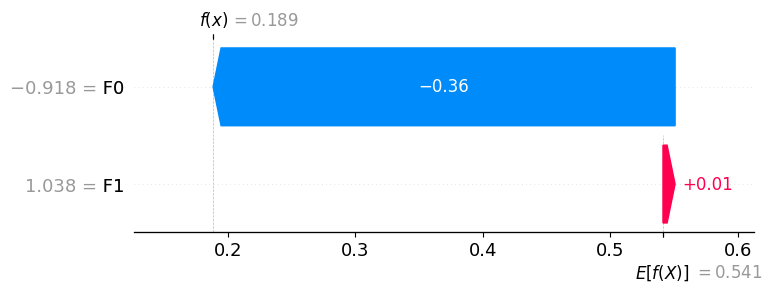

/usr/local/lib/python3.11/dist-packages/shap/plots/_force_matplotlib.py:107: RuntimeWarning: divide by zero encountered in scalar divide
  feature_contribution = np.abs(float(feature[0]) - pre_val) / np.abs(total_effect)


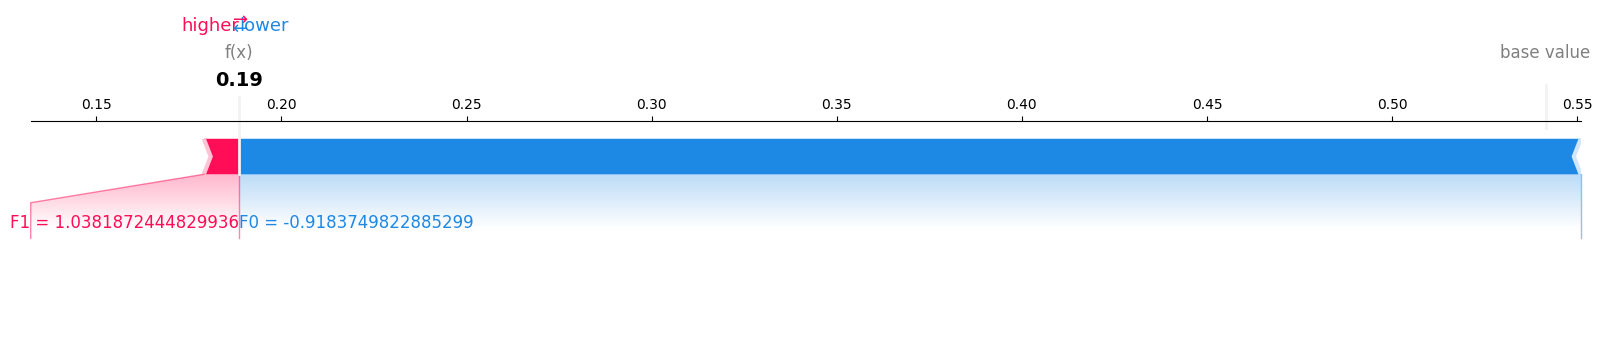

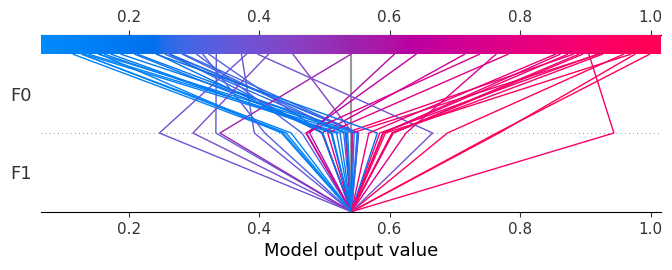

In [24]:
#!pip install shap
import shap

shap.initjs()
explainer = shap.Explainer(rf, X_train) # will automatically select TreeExplainer for rf model
shap_values = explainer(X_test, check_additivity=False)

print("shap_values.values.shape:", shap_values.values.shape)

num_classes = shap_values.values.shape[2]

# for entire class 1 (assuming 1 = positive class)
shap.plots.bar(shap_values[..., 1])
shap.plots.beeswarm(shap_values[..., 1])

# for one prediction
shap.plots.waterfall(shap_values[1, :, 1])
shap.initjs()
shap.plots.force(shap_values[1, :, 1], matplotlib=True)

# multiple predictions
if not isinstance(X_test, pd.DataFrame):  # convert to DF
    feature_names = [f"F{i}" for i in range(X.shape[1])]
    X_test = pd.DataFrame(X_test, columns=feature_names)

shap.decision_plot(
    explainer.expected_value[1],           # base value for class 1
    shap_values.values[:50, :, 1],          # SHAP values for class 1
    X_test.iloc[:50]                        # features for those same samples
)
